# Arbitrage Betting Strategies
---
- Author: Matthew Thoomkuzhy

- Date: 29/01/2025

- Aim: To investigate the nature of arbitrage opportunities over the sample, to inform and devise an arbitrage betting strategy 
---

# 1. Introduction

This notebook will largely consist of exploratory data analysis where we explore and identify patterns involving arbitrage opportunities for premier league matches from 2020 to 2025.

**Key questions I aim to answer:**



- How has the prevelance of arbitrage opportunities changed over time?, is it periodic? (i.e. more opportunites at the start of every season)


- When arbitrage opportunities are present what is the distribution of odds differences among outcomes, is there a clear favourite or are the games implicitly 'close'


- How do full time results vary with odds differences, can this information be used to inform when to use biased vs unbiased arbitrage?

- How do different arbitrage strategies fare over the sample period (2020-2025) ?



---
# 2. Importing Libraries

In [39]:
from functions import process_row , process_odds_data
import pandas as pd
from sqlalchemy import create_engine
from lets_plot import * 
from lets_plot import ggsave
from IPython.display import SVG
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

---
# 3.  Obtaining DF from DB

In [40]:
engine = create_engine('sqlite:///../data/sports_odds.db')
odds_df = pd.read_sql('SELECT * FROM historical_odds', con=engine)
results_df = pd.read_sql('SELECT * FROM match_results', con=engine)

# Using imported functions to get DF
merged_df = process_odds_data(odds_df, results_df,process_row)
merged_df 


,fixture_id,Date,home_team,away_team,FTR,max_home,home_bookmaker,max_away,away_bookmaker,max_draw,draw_bookmaker
0,AVLSHU170620,17/06/2020,Aston Villa,Sheffield United,D,3.35,Unibet,2.41,Marathon Bet,3.52,Marathon Bet
1,MCIARS170620,17/06/2020,Manchester City,Arsenal,H,1.39,Marathon Bet,8.70,Marathon Bet,5.95,Marathon Bet
2,TOTMUN190620,19/06/2020,Tottenham Hotspur,Manchester United,D,2.88,Betfair,2.64,Marathon Bet,3.70,Marathon Bet
3,WATLEI200620,20/06/2020,Watford,Leicester City,D,3.52,Marathon Bet,2.22,Marathon Bet,3.75,Marathon Bet
4,WHUWOL200620,20/06/2020,West Ham United,Wolverhampton Wanderers,A,3.70,Betfair,2.23,Marathon Bet,3.60,Marathon Bet
...,...,...,...,...,...,...,...,...,...,...,...
1777,FULARS081224,08/12/2024,Fulham,Arsenal,D,6.40,Smarkets,1.62,BoyleSports,4.33,Sky Bet
1778,IPSBOU081224,08/12/2024,Ipswich Town,Bournemouth,A,3.20,Paddy Power,2.20,Smarkets,3.90,Betfair
1779,LEIBHA081224,08/12/2024,Leicester City,Brighton and Hove Albion,D,5.00,Paddy Power,1.73,BoyleSports,4.40,Coral
1780,TOTCHE081224,08/12/2024,Tottenham Hotspur,Chelsea,A,2.30,Paddy Power,3.10,Smarkets,3.75,Sky Bet


---
# 4. prevalence of arbitrage opportunities over time

Now I am going to be implementing code logic for arbitrage opportunities,
grouping opportunities for each event by commence time and
then plotting a time series graph for the prevalence of arbitrage opportunities over time.

**Code for arbitrage logic**:

- I implement the formula (1/oddsH + 1/oddsD + 1/oddsA) for each event and check if < or > 1, if less than one, then an arbitrage opportunity exists.

C:\Users\jogim\AppData\Local\Temp\ipykernel_11304\3266912182.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  arb_freq = df.groupby("Date").apply(check_arbitrage)


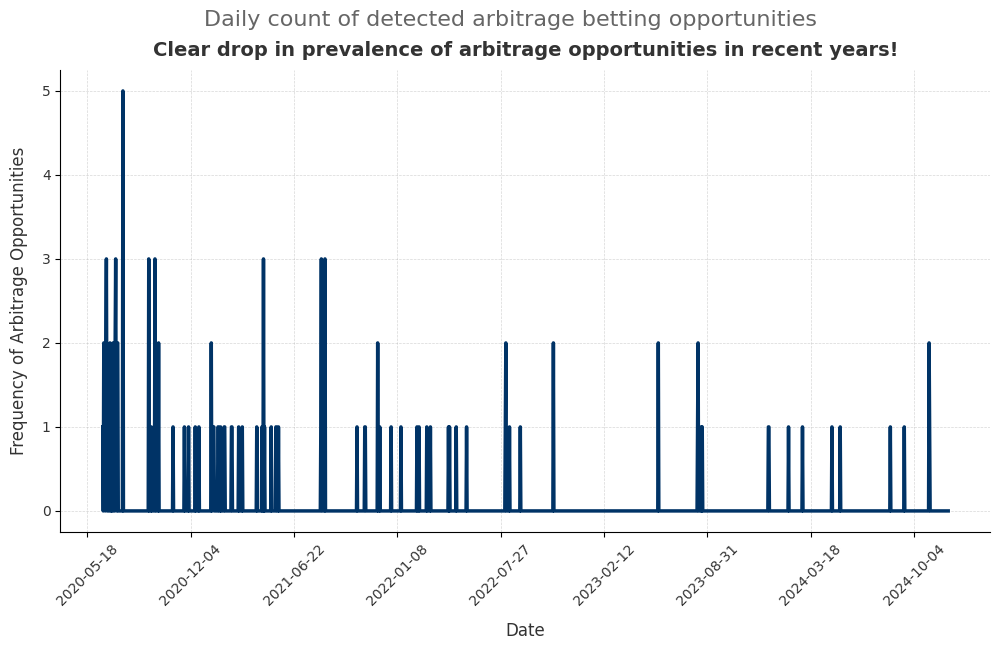

In [41]:


def plot_arbitrage_over_time(df):

    # Ensure required columns exist
    required_columns = {"Date", "max_home", "max_away", "max_draw"}
    if not required_columns.issubset(df.columns):
        raise ValueError(f"Missing required columns: {required_columns - set(df.columns)}")

    # Copy dataframe to avoid modifying the original
    df = df.copy()

    # Convert Date column to datetime format
    df["Date"] = pd.to_datetime(df["Date"], format="%d/%m/%Y")

    # Filter out invalid odds (0 or NaN)
    df = df.dropna(subset=["max_home", "max_away", "max_draw"])
    df = df[(df["max_home"] > 0) & (df["max_away"] > 0) & (df["max_draw"] > 0)]

    # **Optimized arbitrage detection using groupby + apply**
    def check_arbitrage(group):
        
        arb_values = (1 / group["max_home"]).combine(
            (1 / group["max_away"]), func=lambda x, y: x + y
        ).combine(
            (1 / group["max_draw"]), func=lambda x, y: x + y
        )
        return (arb_values < 1).sum()  # Count arbitrage opportunities in the group

    # Apply group-wise arbitrage detection
    arb_freq = df.groupby("Date").apply(check_arbitrage)

    # Ensure all dates are represented in the time series
    arb_freq = arb_freq.resample("D").sum().fillna(0)

    # Plotting
    plt.figure(figsize=(12, 6))

    plt.plot(arb_freq.index, arb_freq.values, color="#003366", linewidth=2.5)

    # Titles and labels
    plt.title("Clear drop in prevalence of arbitrage opportunities in recent years!", fontsize=14, fontweight="bold", pad=10, color="#333333")
    plt.suptitle("Daily count of detected arbitrage betting opportunities", fontsize=16, color="#666666")

    plt.xlabel("Date", fontsize=12, color="#333333", labelpad=10)
    plt.ylabel("Frequency of Arbitrage Opportunities", fontsize=12, color="#333333", labelpad=10)

    # Grid with subtlety
    plt.grid(which="major", linestyle="--", linewidth=0.5, alpha=0.5)

    # Adjust x-axis for cleaner date formatting
    plt.xticks(rotation=45, fontsize=10, color="#333333")
    plt.yticks(fontsize=10, color="#333333")
    plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(10))  # Limits number of x-ticks

    # Remove chart border for cleaner look
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)
    
    # Save plot as a file
    plt.savefig("../data/visualisations/arb_betting_strategies/arb_opportunity_frequency.png", bbox_inches='tight')

    # Display the plot
    plt.show()
    


# Apply the function to the dataset
plot_arbitrage_over_time(merged_df)


### Insight: 

Visually we can see there has been a large dropoff in the number of abritrage opportunities detected daily. Previously there were many days where 2+, 3+ daily opportunities where present whereas now there are long periods where no opportunities are detected at all!

**Informing Backtesting strategy:** The data shows arb may yield lucrative for 2020 but for more recent years the effectvieness of arbitrage is lower

**this may suggests the bookies are becoming more co-ordinated in their odds offerred and arbitrage is dying**

To investigate this further I want to investigate the **profit margins of arbitrage**, a fall in profit margins from arbitrage could be indiciative of lower odds deviation between bookmakers:

---

# 5. Distribution of arbitrage profit margins over time



1. To investigate how faily profit margins are varying I have worked out the most profitable event in each day of the sample.

2. I then used this as an indication of the profitability of that day (days wiht no arb opportunities would be zero)

3. I have decided against using a geometric total for days with >1 arb. ie. multiplying profit margins for each event in that day together. This is as events ususally clash in time due to match scheduling, therefore its impossible to bet on both events simultaneously wihout splitting funds from an inital bankroll

**Logic for profit margins**


I implement the formula 100 x  (1- (1/oddsH + 1/oddsD + 1oddsA)) for each arbitrage event to work out the profit margin (%) of that event

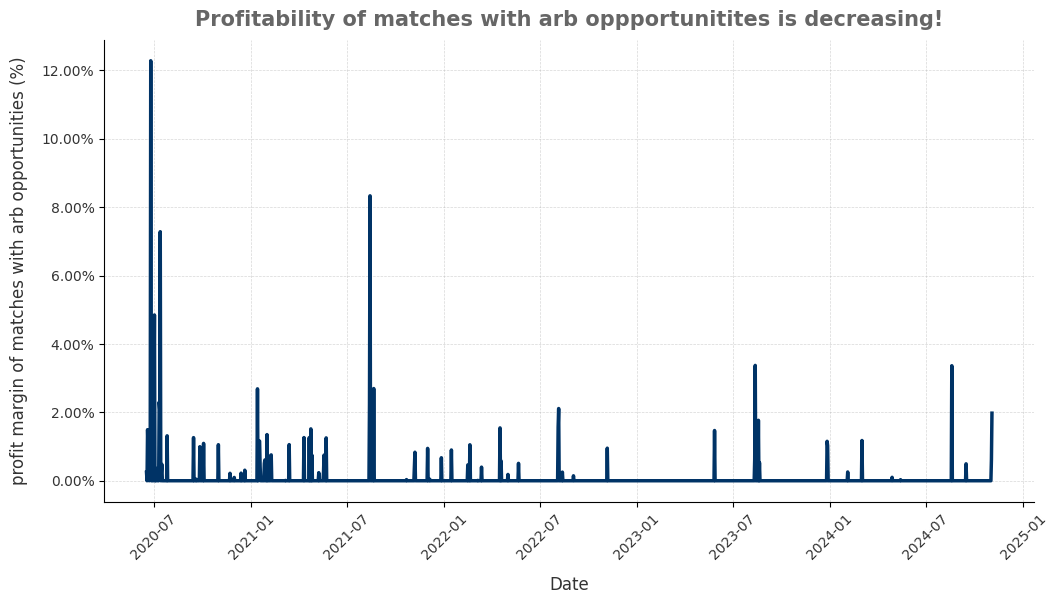

In [42]:


def plot_max_arbitrage_profitability(df):

    required_columns = {"Date", "max_home", "max_away", "max_draw"}
    if not required_columns.issubset(df.columns):
        raise ValueError(f"Missing required columns: {required_columns - set(df.columns)}")

    df = df.copy()
    df["Date"] = pd.to_datetime(df["Date"], format="%d/%m/%Y")

    df = df.dropna(subset=["max_home", "max_away", "max_draw"])
    df = df[(df["max_home"] > 0) & (df["max_away"] > 0) & (df["max_draw"] > 0)]

    df["arbitrage_margin"] = 1 - ((1 / df["max_home"]) + (1 / df["max_away"]) + (1 / df["max_draw"]))
    df = df[df["arbitrage_margin"] > 0]

    # Get the most profitable arbitrage event per day
    daily_max_profit = df.groupby("Date")["arbitrage_margin"].max()

    # Reindex to include all days, filling missing values with 0
    daily_max_profit = daily_max_profit.reindex(pd.date_range(df["Date"].min(), df["Date"].max()), fill_value=0)

    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(daily_max_profit.index, daily_max_profit.values, color="#003366", linewidth=2.5)

    plt.title("Profitability of matches with arb oppportunitites is decreasing!", fontsize=15, pad= 10 ,color="#666666", fontweight="bold")

    plt.xlabel("Date", fontsize=12, color="#333333", labelpad=10)
    plt.ylabel("profit margin of matches with arb opportunities (%)", fontsize=12, color="#333333", labelpad=10)

    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x*100:.2f}%"))
    plt.grid(which="major", linestyle="--", linewidth=0.5, alpha=0.5)

    plt.xticks(rotation=45, fontsize=10, color="#333333")
    plt.yticks(fontsize=10, color="#333333")
    

    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)
    plt.savefig("../data/visualisations/arb_betting_strategies/arbitrage_profit_margin_timeline.png", bbox_inches='tight')


plot_max_arbitrage_profitability(merged_df)


### Insight:

The existence of large arbitrage profit margins has diminished, as in 2020 many margins over 4% were present however these are long gone

However periodically we observe there is a spike in margins every year at a similar time, I want to investigate this further. 

---

# 6. Seasonality of arbitrage opportunities

I am going to be grouping events by month then producing a bar chart visualisation to satiate my insight about seasonality of arbitrage opportunities.

The bar chart will display number of arbitrage opportunities by month (regardless of year)

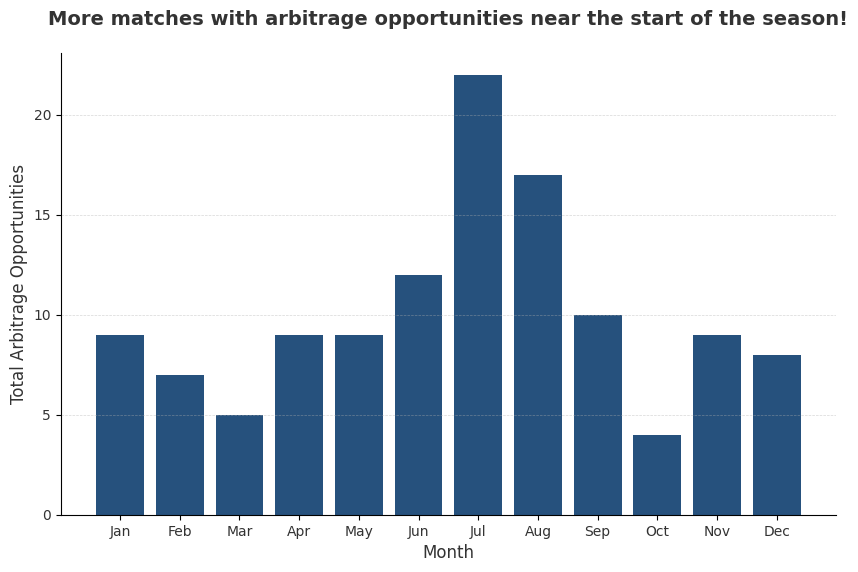

In [43]:


def plot_arbitrage_opportunities_by_month(df):

    required_columns = {"Date", "max_home", "max_away", "max_draw"}
    if not required_columns.issubset(df.columns):
        raise ValueError(f"Missing required columns: {required_columns - set(df.columns)}")

    df = df.copy()
    df["Date"] = pd.to_datetime(df["Date"], format="%d/%m/%Y")

    df = df.dropna(subset=["max_home", "max_away", "max_draw"])
    df = df[(df["max_home"] > 0) & (df["max_away"] > 0) & (df["max_draw"] > 0)]

    df["arbitrage_margin"] = 1 - ((1 / df["max_home"]) + (1 / df["max_away"]) + (1 / df["max_draw"]))
    df["Month"] = df["Date"].dt.month  # Extract month as a number

    # Count arbitrage occurrences per month (regardless of year)
    monthly_arb_counts = df[df["arbitrage_margin"] > 0]["Month"].value_counts().sort_index()

    # Define month names for better readability
    month_labels = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

    # Plot
    plt.figure(figsize=(10, 6))
    plt.bar(month_labels, monthly_arb_counts, color="#003366", alpha=0.85)

    plt.title("More matches with arbitrage opportunities near the start of the season!", fontsize=14, fontweight="bold", pad=20, color="#333333")
    plt.xlabel("Month", fontsize=12, color="#333333")
    plt.ylabel("Total Arbitrage Opportunities", fontsize=12, color="#333333")

    plt.grid(axis="y", linestyle="--", linewidth=0.5, alpha=0.5)
    plt.xticks(fontsize=10, color="#333333")
    plt.yticks(fontsize=10, color="#333333")

    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)
    
    # Save plot as a file
    plt.savefig("../data/visualisations/arb_betting_strategies/arbitrage_opportunities_by_month.png", bbox_inches='tight')

    plt.show()
    


# Example Usage:
plot_arbitrage_opportunities_by_month(merged_df)


### Insight:

The clear spike in the number of arbitrage opportunities in June July and August (the 3 most popular months) implies that **arbitrage is most effective at the start of the season**

This is likely due to **greater uncertainty at the start of the season** as to who has a stronger and weaker team, and less recent form data means that bookmakers will show **greater deviations in pricing odds**.

**Informing Backtesting strategy:** The data shows that a higher weighting should be placed on arbitrage during the early season months due to their increased frequency

I want to further investigate deviations in pricing odds.

---
# 7. Nature of odds pricing in arbitrage events

First I begin by calculating the size of the sample for arbitrage games

In [44]:
# Ensure arbitrage margin is calculated
merged_df["arbitrage_margin"] = 1 - ((1 / merged_df["max_home"]) + (1 / merged_df["max_away"]) + (1 / merged_df["max_draw"]))

# Ensure only valid arbitrage opportunities are counted
total_arb_opportunities = (merged_df["arbitrage_margin"] > 0).sum()

print("Total Arbitrage Opportunities:", total_arb_opportunities)


Total Arbitrage Opportunities: 121


121 is a sufficiently large sample (of arbitrage matches) to draw observations regarding the nature of arbitrage

First I want to investigate the odds difference for arbitrage events by plottign the desnity of odds difference for arbitrage events

**Logic for odds difference**:

The odds difference has been calculated by doign abs(home odds - away odds) the lower the odds difference is, this implies the game is closer and tehre isn't a 'favourite team'. Thus i will be using the odds difference as a measure of the closeness of games

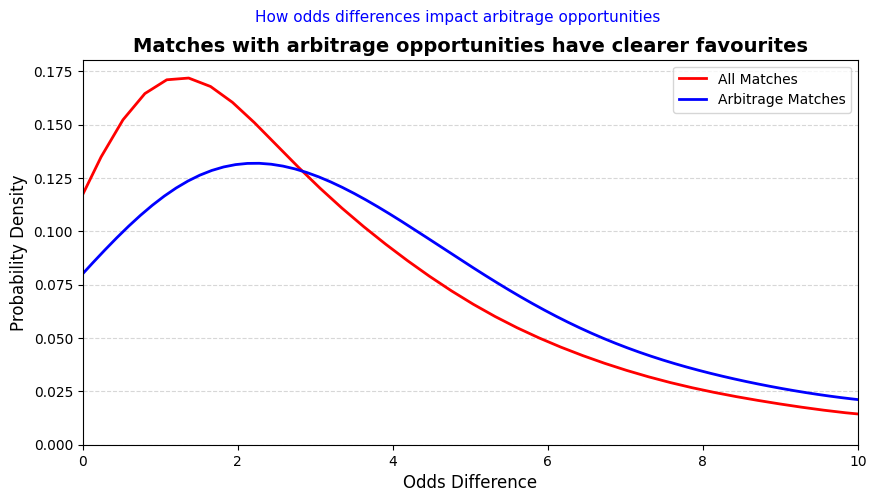

In [45]:

# Copy and clean the dataframe
merged_df = merged_df.copy()
merged_df = merged_df.dropna(subset=["max_home", "max_away", "max_draw"])
merged_df = merged_df[(merged_df["max_home"] > 0) & (merged_df["max_away"] > 0) & (merged_df["max_draw"] > 0)]

# Calculate arbitrage margin
merged_df["arbitrage_margin"] = 1 - ((1 / merged_df["max_home"]) + (1 / merged_df["max_away"]) + (1 / merged_df["max_draw"]))

# Compute odds difference for all matches
merged_df['odds_difference'] = abs(merged_df['max_home'] - merged_df['max_away'])

# Filter only arbitrage events
arb_events_df = merged_df[merged_df["arbitrage_margin"] > 0].copy()

# Drop missing values and ensure 'odds_difference' is numeric
merged_df = merged_df.dropna(subset=['odds_difference'])
arb_events_df = arb_events_df.dropna(subset=['odds_difference'])

merged_df['odds_difference'] = pd.to_numeric(merged_df['odds_difference'])
arb_events_df['odds_difference'] = pd.to_numeric(arb_events_df['odds_difference'])

# Plot hollow density curves
plt.figure(figsize=(10, 5))

# Density of all matches (hollow red line)
sns.kdeplot(merged_df['odds_difference'], color='red', linewidth=2, label='All Matches')

# Density of arbitrage matches (hollow blue line)
sns.kdeplot(arb_events_df['odds_difference'], color='blue', linewidth=2, label='Arbitrage Matches')

# Formatting
plt.xlim(0, 10)
plt.xlabel("Odds Difference", fontsize=12)
plt.ylabel("Probability Density", fontsize=12)
plt.title("Matches with arbitrage opportunities have clearer favourites", fontsize=14, fontweight='bold')
plt.suptitle("How odds differences impact arbitrage opportunities", fontsize=11, color='blue')

# Add legend
plt.legend()

# Save plot to a file
plt.savefig("../data/visualisations/arb_betting_strategies/arbitrage_density.png", bbox_inches='tight')

# Show plot
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


### Insight:

Both matches and arbitrage matches follow a normal distribution

The peak of the arbitrage match density graph occurs further to the right, which suggests that **arbitrage matches occur where the odds difference is higher**, so there is a clear winner and loser

The peak also occurs higher, which suggests that odds deviate more between games for arbitrage events. Arbitrage events occur more commonly across a wider range of odds differences.

**This implies bookmakers compete on non-close games**

I want to look into this more concretely with statistsics:

In [46]:

# Calculate arbitrage margin
merged_df["arbitrage_margin"] = 1 - ((1 / merged_df["max_home"]) + (1 / merged_df["max_away"]) + (1 / merged_df["max_draw"]))

# Compute odds difference
merged_df["odds_difference"] = abs(merged_df["max_home"] - merged_df["max_away"])

# Separate arbitrage and non-arbitrage matches
arb_events_df = merged_df[merged_df["arbitrage_margin"] > 0].copy()  # Arbitrage matches
non_arb_events_df = merged_df[merged_df["arbitrage_margin"] <= 0].copy()  # Non-arbitrage matches

# Calculate mean and standard deviation for each distribution
stats = {
    "Distribution": ["All Matches", "Arbitrage Matches", "Non-Arbitrage Matches"],
    "Mean Odds Difference": [
        np.nanmean(merged_df['odds_difference']),
        np.nanmean(arb_events_df['odds_difference']),
        np.nanmean(non_arb_events_df['odds_difference'])
    ],
    "Standard Deviation": [
        np.nanstd(merged_df['odds_difference']),
        np.nanstd(arb_events_df['odds_difference']),
        np.nanstd(non_arb_events_df['odds_difference'])
    ]
}

# Convert to DataFrame and display
stats_df = pd.DataFrame(stats)
print(stats_df)


            Distribution  Mean Odds Difference  Standard Deviation
0            All Matches              3.871906            4.694607
1      Arbitrage Matches              4.430992            4.236917
2  Non-Arbitrage Matches              3.831104            4.723684


The table above shows an almost 0.5 greater odds difference for arb games, implying arb games have a clear winner and loser. 

It also shows a 0.5 smaller standard deviation implying odds are less widely varied, this implies that events with extreme odds sifferences are more likely to be 'arbable'

Now I want to investigate the nature of otucomes in regards to arb opportunities and odds differences, I will be usiong this to set thresholds for when to use biased vs non-biased arb in strategies

---
# 8. When to use biased vs non - biased arb

To help devise a more successful strategy I want to find conditions in which biased arb vs non-biased arb will be more successful.

Unbiased arb involves betting in a way so that the same profit is made regardless of outcome. On the other hand, biased arb involves a 'triple or nothing approach' where more profit is made if the biased event occurs, but none is made if another event occurs 

by examining the FTR column relative to the odds differences of each event, I want to find out when it is optimal to employ biased arb rather than unbiased arb

C:\Users\jogim\AppData\Local\Temp\ipykernel_11304\3329403047.py:35: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  win_rates_all = non_arb_df.groupby("odds_bin")["favorite_won"].mean().reset_index()
C:\Users\jogim\AppData\Local\Temp\ipykernel_11304\3329403047.py:36: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  win_rates_arb = arb_events_df.groupby("odds_bin")["favorite_won"].mean().reset_index()


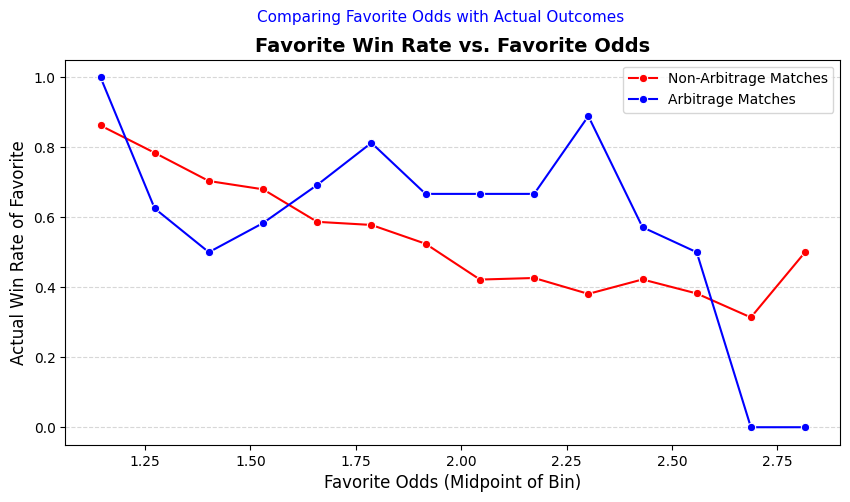

In [47]:


# ---- Compute Favorite Outcome and Whether Favorite Won ----
# Identify the favorite outcome as the team with the lower odds (from max_home and max_away).
merged_df["favorite_outcome"] = merged_df[["max_home", "max_away"]].idxmin(axis=1)

# Define a mapping: if the favorite is from "max_home", a home win ("H") counts as a win;
# if from "max_away", then an away win ("A") counts.
favorite_mapping = {"max_home": "H", "max_away": "A"}

# Compute whether the favorite won (1) or lost (0)
merged_df["favorite_won"] = merged_df.apply(
    lambda row: int(row["FTR"] == favorite_mapping.get(row["favorite_outcome"], None)),
    axis=1
)

# ---- Compute Favorite Odds (Lower of Home and Away Odds) ----
merged_df["favorite_odds"] = merged_df[["max_home", "max_away"]].min(axis=1)

# ---- Split Data into Arbitrage and Non-Arbitrage Matches ----
# Extract arbitrage matches (where arbitrage_margin > 0)
arb_events_df = merged_df[merged_df["arbitrage_margin"] > 0].copy()
# Extract non-arbitrage matches (where arbitrage_margin <= 0)
non_arb_df = merged_df[merged_df["arbitrage_margin"] <= 0].copy()

# ---- Bin Data by Favorite Odds ----
# Define bins from the minimum to maximum favorite odds (across all matches)
odds_min = merged_df["favorite_odds"].min()
odds_max = merged_df["favorite_odds"].max()
odds_bins = np.linspace(odds_min, odds_max, 15)  # Using 15 bins; adjust as needed

# Create odds bins for both subsets
non_arb_df["odds_bin"] = pd.cut(non_arb_df["favorite_odds"], bins=odds_bins, right=False)
arb_events_df["odds_bin"] = pd.cut(arb_events_df["favorite_odds"], bins=odds_bins, right=False)

# ---- Compute Win Rate per Odds Bin ----
win_rates_all = non_arb_df.groupby("odds_bin")["favorite_won"].mean().reset_index()
win_rates_arb = arb_events_df.groupby("odds_bin")["favorite_won"].mean().reset_index()

# Compute the midpoint of each odds bin for plotting
win_rates_all["odds_mid"] = win_rates_all["odds_bin"].apply(lambda x: (x.left + x.right) / 2)
win_rates_arb["odds_mid"] = win_rates_arb["odds_bin"].apply(lambda x: (x.left + x.right) / 2)

# ---- Plot Win Rate vs. Favorite Odds ----
plt.figure(figsize=(10, 5))

# Plot win rate for non-arbitrage matches (all matches excluding arbitrage) in red.
sns.lineplot(x=win_rates_all["odds_mid"], y=win_rates_all["favorite_won"],
             marker="o", color="red", label="Non-Arbitrage Matches")

# Plot win rate for arbitrage matches in blue.
sns.lineplot(x=win_rates_arb["odds_mid"], y=win_rates_arb["favorite_won"],
             marker="o", color="blue", label="Arbitrage Matches")

# Formatting the plot.
plt.xlabel("Favorite Odds (Midpoint of Bin)", fontsize=12)
plt.ylabel("Actual Win Rate of Favorite", fontsize=12)
plt.title("Favorite Win Rate vs. Favorite Odds", fontsize=14, fontweight="bold")
plt.suptitle("Comparing Favorite Odds with Actual Outcomes", fontsize=11, color="blue")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend()

# Save and show plot.
plt.savefig("../data/visualisations/arb_betting_strategies/fav_win_vs_favorite_odds.png", bbox_inches="tight")
plt.show()


This shows that matches with arbitrage opporutnities have higher success rates for the favourite team for higher odds. Suggesting arbitrage is more successful for **weaker favourites**

C:\Users\jogim\AppData\Local\Temp\ipykernel_11304\1407113865.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  win_rates_all = non_arb_df.groupby("odds_bin")["middle_outcome_won"].mean().reset_index()
C:\Users\jogim\AppData\Local\Temp\ipykernel_11304\1407113865.py:38: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  win_rates_arb = arb_events_df.groupby("odds_bin")["middle_outcome_won"].mean().reset_index()


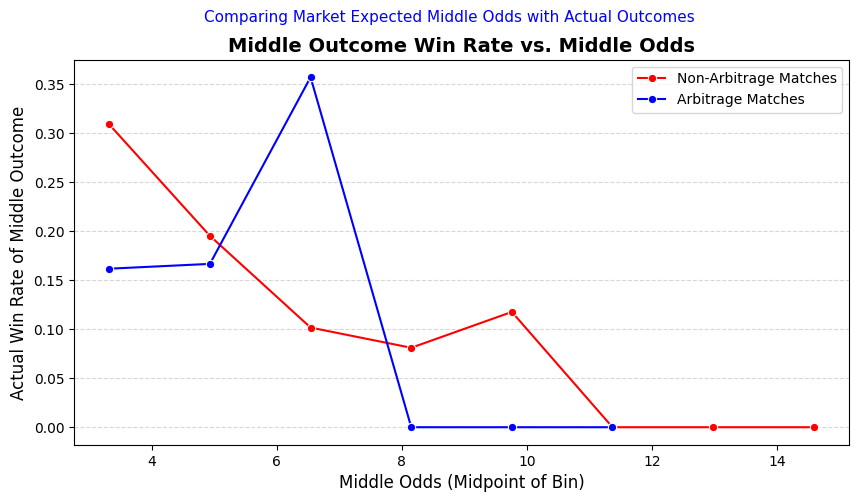

In [48]:
# ---- Identify Middle-Priced Outcome ----
def get_middle_priced_outcome(row):
    odds = {"H": row["max_home"], "A": row["max_away"], "D": row["max_draw"]}
    sorted_outcomes = sorted(odds.items(), key=lambda x: x[1])  # Sort outcomes by odds value
    return sorted_outcomes[1][0]  # Return the outcome with the second-lowest odds

merged_df["middle_outcome"] = merged_df.apply(get_middle_priced_outcome, axis=1)

# ---- Assign Whether the Middle-Priced Outcome Won ----
merged_df["middle_outcome_won"] = merged_df.apply(
    lambda row: row["FTR"] == row["middle_outcome"], axis=1
).astype(int)

# ---- Compute Middle Odds (Second Lowest Odds) ----
# This gives the actual odds value for the middle-priced outcome.
merged_df["middle_odds"] = merged_df[["max_home", "max_away", "max_draw"]].apply(
    lambda x: sorted(x)[1], axis=1
)

# ---- Split Data: Arbitrage Matches vs. Non-Arbitrage Matches ----
# Arbitrage matches:
arb_events_df = merged_df[merged_df["arbitrage_margin"] > 0].copy()
# Non-arbitrage (All Matches excluding arbitrage):
non_arb_df = merged_df[merged_df["arbitrage_margin"] <= 0].copy()

# ---- Compute Win Rates by Middle Odds Bins ----
# Define bins across the range of middle odds using the full data range.
odds_min = merged_df["middle_odds"].min()
odds_max = merged_df["middle_odds"].max()
odds_bins = np.linspace(odds_min, odds_max, 10)  # 15 bins; adjust as needed

# Bin the middle odds for both non-arbitrage and arbitrage datasets.
non_arb_df["odds_bin"] = pd.cut(non_arb_df["middle_odds"], bins=odds_bins, right=False)
arb_events_df["odds_bin"] = pd.cut(arb_events_df["middle_odds"], bins=odds_bins, right=False)

# Compute win rate per middle odds bin.
win_rates_all = non_arb_df.groupby("odds_bin")["middle_outcome_won"].mean().reset_index()
win_rates_arb = arb_events_df.groupby("odds_bin")["middle_outcome_won"].mean().reset_index()

# Calculate the midpoint of each odds bin for plotting.
win_rates_all["odds_mid"] = win_rates_all["odds_bin"].apply(lambda x: (x.left + x.right) / 2)
win_rates_arb["odds_mid"] = win_rates_arb["odds_bin"].apply(lambda x: (x.left + x.right) / 2)

# ---- Plot Middle Outcome Win Rate vs. Middle Odds ----
plt.figure(figsize=(10, 5))

# Plot for non-arbitrage matches (All Matches excluding arbitrage) in red.
sns.lineplot(x=win_rates_all["odds_mid"], y=win_rates_all["middle_outcome_won"],
             marker="o", color="red", label="Non-Arbitrage Matches")

# Plot for arbitrage matches in blue.
sns.lineplot(x=win_rates_arb["odds_mid"], y=win_rates_arb["middle_outcome_won"],
             marker="o", color="blue", label="Arbitrage Matches")

# Formatting the plot.
plt.xlabel("Middle Odds (Midpoint of Bin)", fontsize=12)
plt.ylabel("Actual Win Rate of Middle Outcome", fontsize=12)
plt.title("Middle Outcome Win Rate vs. Middle Odds", fontsize=14, fontweight="bold")
plt.suptitle("Comparing Market Expected Middle Odds with Actual Outcomes", fontsize=11, color="blue")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend()

# Save and show plot.
plt.savefig("../data/visualisations/arb_betting_strategies/middle_outcome_win_vs_middle_odds.png", bbox_inches="tight")
plt.show()


This shows that matches with arbitrage opporutnities have higher success rates for the middle between odds 6-7

C:\Users\jogim\AppData\Local\Temp\ipykernel_11304\4167386923.py:33: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  win_rates_all_underdog = non_arb_df.groupby("odds_bin")["underdog_won_or_draw"].mean().reset_index()
C:\Users\jogim\AppData\Local\Temp\ipykernel_11304\4167386923.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  win_rates_arb_underdog = arb_events_df.groupby("odds_bin")["underdog_won_or_draw"].mean().reset_index()


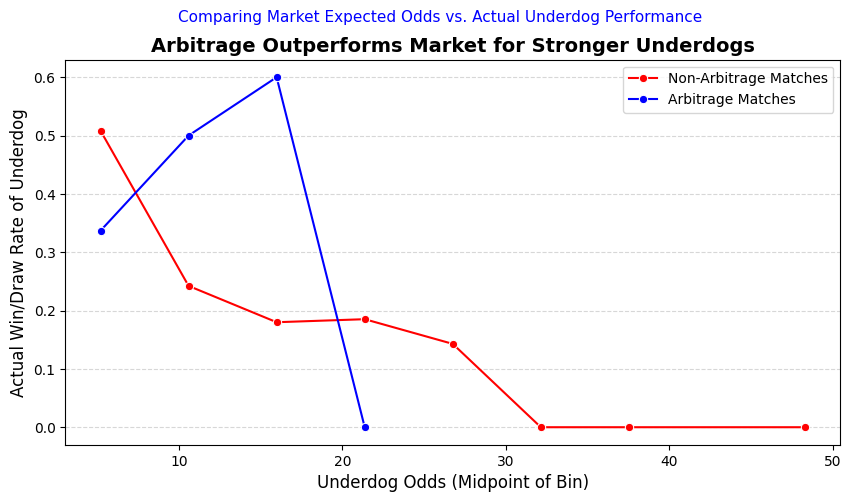

In [49]:
# ---- Compute Underdog Odds ----
# The underdog is defined as the team with the highest odds (from max_home and max_away)
merged_df["underdog_odds"] = merged_df[["max_home", "max_away"]].max(axis=1)

# ---- Determine Underdog Outcome (Including Draws) ----
# Identify which team is the underdog based on the odds.
merged_df["underdog_outcome"] = merged_df[["max_home", "max_away"]].idxmax(axis=1)

# Corrected mapping: if underdog is max_home, then a home win ("H") counts as a win, and similarly for max_away.
outcome_mapping = {"max_home": "H", "max_away": "A"}

# Assign whether the underdog won or the match was a draw
merged_df["underdog_won_or_draw"] = merged_df.apply(
    lambda row: (row["FTR"] == outcome_mapping.get(row["underdog_outcome"], None)) or (row["FTR"] == "D"),
    axis=1
).astype(int)

# ---- Split Data: Arbitrage Matches vs. Non-Arbitrage Matches ----
arb_events_df = merged_df[merged_df["arbitrage_margin"] > 0].copy()
non_arb_df   = merged_df[merged_df["arbitrage_margin"] <= 0].copy()

# ---- Bin Data by Underdog Odds ----
# Define bins spanning the range of underdog odds using the full data range.
odds_min = merged_df["underdog_odds"].min()
odds_max = merged_df["underdog_odds"].max()
odds_bins = np.linspace(odds_min, odds_max, 10)  # Using 10 bins; adjust as needed

# Create odds bins for both non-arbitrage and arbitrage datasets.
non_arb_df["odds_bin"] = pd.cut(non_arb_df["underdog_odds"], bins=odds_bins, right=False)
arb_events_df["odds_bin"] = pd.cut(arb_events_df["underdog_odds"], bins=odds_bins, right=False)

# ---- Compute Win/Draw Rates by Underdog Odds Bin ----
win_rates_all_underdog = non_arb_df.groupby("odds_bin")["underdog_won_or_draw"].mean().reset_index()
win_rates_arb_underdog = arb_events_df.groupby("odds_bin")["underdog_won_or_draw"].mean().reset_index()

# Compute the midpoint of each odds bin for plotting.
win_rates_all_underdog["odds_mid"] = win_rates_all_underdog["odds_bin"].apply(lambda x: (x.left + x.right) / 2)
win_rates_arb_underdog["odds_mid"] = win_rates_arb_underdog["odds_bin"].apply(lambda x: (x.left + x.right) / 2)

# ---- Plot Underdog Win/Draw Rate vs. Underdog Odds ----
plt.figure(figsize=(10, 5))

# Plot for non-arbitrage matches (All Matches excluding arbitrage) in red.
sns.lineplot(x=win_rates_all_underdog["odds_mid"], y=win_rates_all_underdog["underdog_won_or_draw"],
             marker="o", color="red", label="Non-Arbitrage Matches")

# Plot for arbitrage matches in blue.
sns.lineplot(x=win_rates_arb_underdog["odds_mid"], y=win_rates_arb_underdog["underdog_won_or_draw"],
             marker="o", color="blue", label="Arbitrage Matches")

# Formatting the plot.
plt.xlabel("Underdog Odds (Midpoint of Bin)", fontsize=12)
plt.ylabel("Actual Win/Draw Rate of Underdog", fontsize=12)
plt.title("Arbitrage Outperforms Market for Stronger Underdogs", fontsize=14, fontweight="bold")
plt.suptitle("Comparing Market Expected Odds vs. Actual Underdog Performance", fontsize=11, color="blue")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend()

# Save and show plot.
plt.savefig("../data/visualisations/arb_betting_strategies/underdog_win_draw_vs_odds.png", bbox_inches="tight")
plt.show()


This shows that matches with arbitrage opporutnities have higher success rates for the underdog team for lower odds. Suggesting arbitrage is more successful for **strong underdogs**

### Insights:

From the 3 graphs below we can infer that arbitrage events has higher sucess rates compared to the market when: i.) there is a weak favourite ii.) there is a strong underdog

There aren't any singificant trends indicating arbitrage outcomes are any more probable than the aggregate market for the 2nd best outcome, for when the likelyhood of the 2nd outcome is strong, arbitrage opportunties prevail at a rate much lower than the market average.

I am going to be using this to be informing biased arbitrage back

    

---
# 9. Backtesting unbiased arb strategy:

Now I am going to begin backtesting a basic unbiased arbitrage strategy, for this I will create a function to plot unbiased arb events

C:\Users\jogim\AppData\Local\Temp\ipykernel_11304\1523133831.py:5: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  arb_events_df["Date"] = pd.to_datetime(arb_events_df["Date"])


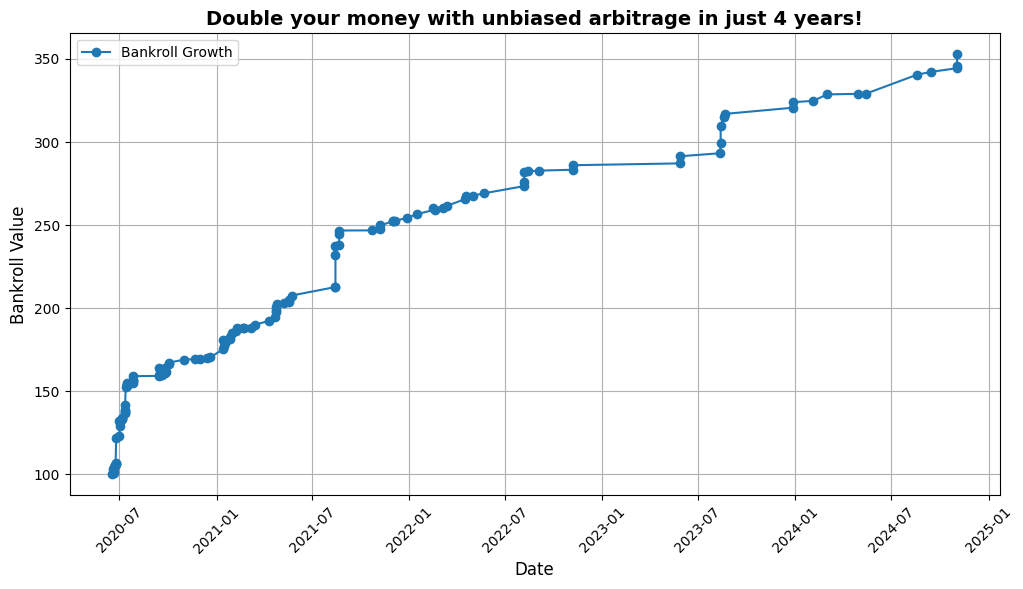

In [50]:

def simulate_unbiased_arb(arb_events_df, starting_bankroll, start_date, end_date):


    # Convert Date column to datetime
    arb_events_df["Date"] = pd.to_datetime(arb_events_df["Date"])

    # Filter data for the specified time period
    filtered_df = arb_events_df[(arb_events_df["Date"] >= start_date) & (arb_events_df["Date"] <= end_date)].copy()

    # Ensure the required columns exist
    required_columns = {"Date", "max_home", "max_away", "max_draw", "FTR"}
    if not required_columns.issubset(filtered_df.columns):
        raise ValueError(f"Missing required columns: {required_columns - set(filtered_df.columns)}")

    # Initialize bankroll
    bankroll = starting_bankroll
    bankroll_history = []

    # Loop through arbitrage opportunities and simulate bets
    for _, row in filtered_df.iterrows():
        # Compute arbitrage stake allocation for equal profit
        odds = [row["max_home"], row["max_away"], row["max_draw"]]
        total_investment = sum(1 / np.array(odds))

        if total_investment >= 1:  # No guaranteed profit, skip bet
            continue

        # Update stake for this round (entire bankroll)
        stake_per_bet = bankroll

        # Allocate stake based on arbitrage odds (ensures equal profit)
        stake_allocation = (stake_per_bet / total_investment) * (1 / np.array(odds))
        total_stake = sum(stake_allocation)

        # Determine bet outcome
        if row["FTR"] == "H":
            profit = (stake_allocation[0] * row["max_home"]) - total_stake
        elif row["FTR"] == "A":
            profit = (stake_allocation[1] * row["max_away"]) - total_stake
        else:  # Draw outcome
            profit = (stake_allocation[2] * row["max_draw"]) - total_stake

        # Update bankroll (compounded growth)
        bankroll += profit

        # Log bankroll history
        bankroll_history.append([row["Date"], stake_per_bet, profit, bankroll])

    # Convert to DataFrame
    results_df = pd.DataFrame(bankroll_history, columns=["Date", "Bet Placed", "Profit", "Bankroll"])

    # Plot bankroll growth
    plt.figure(figsize=(12, 6))
    plt.plot(results_df["Date"], results_df["Bankroll"], marker="o", linestyle="-", label="Bankroll Growth")
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Bankroll Value", fontsize=12)
    plt.title("Double your money with unbiased arbitrage in just 4 years!", fontsize=14, fontweight="bold")
    plt.legend()
    plt.grid()
    plt.xticks(rotation=45)
    plt.savefig("../data/visualisations/arb_betting_strategies/unbiased_arb_simulation", bbox_inches="tight")
    plt.show()
    

    return results_df

df_results = simulate_unbiased_arb(arb_events_df, starting_bankroll=100, start_date="2020-06-01", end_date="2025-01-01")




### Insight:

Unbiased arbitrage returned approximately 250% in 4.5 years

Although as expected from prior insights, returns have slowed down in recent years

Nonetheless this is still remarkable performance. The S&P 500 returned 82% in 5 years, unbiased arbitrage is over 3x this

---
# 10. Backtesting Bias arb strategies

Now I will be comparing the results of unbiased arbitrage to the results of baised arbitrage, firstly I have created a general function called simulate_arb, I will be using this to generate the plots for the 4 different strategies

Then I will use a 2nd written function plot_arbitrage_strategies to plot the results

I have created a function called simulate_arb, this fucntion allows me to add code logic for when to use bias favourite or none, and applies the logic accordingly

I have created a 2nd function called plot arb comparison which allows me to plto the results for different strategies on the same graph

### Simulate arb function:

accepts logic for backtesting strategies in a modular fashion, so that extra logic and strategies can easily be added

In [51]:
def simulate_arb(arb_events_df, starting_bankroll, start_date, end_date, bias_strategy):
    arb_events_df["Date"] = pd.to_datetime(arb_events_df["Date"], dayfirst=True)
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    
    filtered_df = arb_events_df[(arb_events_df["Date"] >= start_date) & (arb_events_df["Date"] <= end_date)].copy()
    
    required_columns = {"Date", "home_team", "away_team", "FTR", "max_home", "max_away", "max_draw"}
    if not required_columns.issubset(filtered_df.columns):
        raise ValueError(f"Missing required columns: {required_columns - set(filtered_df.columns)}")
    
    bankroll = starting_bankroll
    bankroll_history = []
    
    filtered_df = filtered_df.sort_values("Date")  # Ensure events are processed sequentially
    
    for _, row in filtered_df.iterrows():
        odds_home, odds_away, odds_draw = row["max_home"], row["max_away"], row["max_draw"]
        sorted_odds = sorted([("Home", odds_home), ("Away", odds_away), ("Draw", odds_draw)], key=lambda x: x[1])
        favorite, second_fav, underdog = sorted_odds[0], sorted_odds[1], sorted_odds[2]
        
        fav_implied_prob = 1 / favorite[1]
        underdog_implied_prob = 1 / underdog[1]
        
        bias_type = bias_strategy(fav_implied_prob, underdog_implied_prob)
        
        total_investment = (1 / odds_home) + (1 / odds_away) + (1 / odds_draw)
        if total_investment >= 1:
            continue  # Skip non-arbitrage events
        
        B = bankroll
        P = B / total_investment
        
        stake_home, stake_away, stake_draw = P / odds_home, P / odds_away, P / odds_draw
        base_profit = P - (stake_home + stake_away + stake_draw)
        
        if bias_type != "none":
            if bias_type == "fav":
                bias_event, bias_odds = favorite[:2]
            elif bias_type == "underdog":
                bias_event, bias_odds = underdog[:2]
            elif bias_type == "second":
                bias_event, bias_odds = second_fav[:2]
            
            bias_ftr_map = {"Home": "H", "Away": "A", "Draw": "D"}
            bias_ftr = bias_ftr_map[bias_event]
            
            extra_stake = base_profit
            if bias_event == "Home":
                stake_home += extra_stake
            elif bias_event == "Away":
                stake_away += extra_stake
            else:
                stake_draw += extra_stake
            
            total_stake = stake_home + stake_away + stake_draw
            scale_factor = B / total_stake
            stake_home *= scale_factor
            stake_away *= scale_factor
            stake_draw *= scale_factor
        
        total_stake = stake_home + stake_away + stake_draw
        profit = base_profit
        
        if bias_type != "none":
            if row["FTR"] == bias_ftr:
                stake_bias = stake_home if bias_event == "Home" else stake_away if bias_event == "Away" else stake_draw
                profit = (stake_bias * bias_odds) - total_stake
            else:
                profit = 0
        
        bankroll += profit
        bankroll_history.append([row["Date"], bankroll, profit, stake_home, stake_away, stake_draw, bias_type])
    
    return pd.DataFrame(bankroll_history, columns=["Date", "Bankroll", "Profit", "Stake_Home", "Stake_Away", "Stake_Draw", "Bias_Type"])



the function above backtests logic for different betting strategies

### Plot arb comparison function,

plots the results of a series of strategies which are passed as a list strategies

In [52]:

def plot_arb_comparison(arb_events_df, starting_bankroll, start_date, end_date, strategies, title, name):
    results = {}
    
    # Run each strategy and store the results
    for strategy_name, strategy in strategies.items():
        results[strategy_name] = simulate_arb(
            arb_events_df,
            starting_bankroll,
            start_date,
            end_date,
            strategy
        )
    
    # Create the plot
    plt.figure(figsize=(12, 6))
    for strategy_name, df in results.items():
        df["Date"] = pd.to_datetime(df["Date"])
        df = df.sort_values("Date")
        plt.plot(df["Date"], df["Bankroll"], label=f"Strategy: {strategy_name}")
    
    plt.xlabel("Date")
    plt.ylabel("Bankroll (£)")
    plt.title(title)
    plt.legend()
    plt.grid()
    
    # Ensure the directory exists before saving
    save_dir = "../data/visualisations/arb_betting_strategies"
    os.makedirs(save_dir, exist_ok=True)
    
    # Save the figure
    save_path = os.path.join(save_dir, f"{name}.png")
    plt.savefig(save_path)
    
    # Display the plot
    plt.show()


This function above plots the results of different arbitrage strategies, Now I will be comparing betting strategies with simple logic for bias towards a given event. Note that favourite refers to the outcome with lowest odds (this can be home, away or draw) the second best outcome has 2nd lowest odds etc.

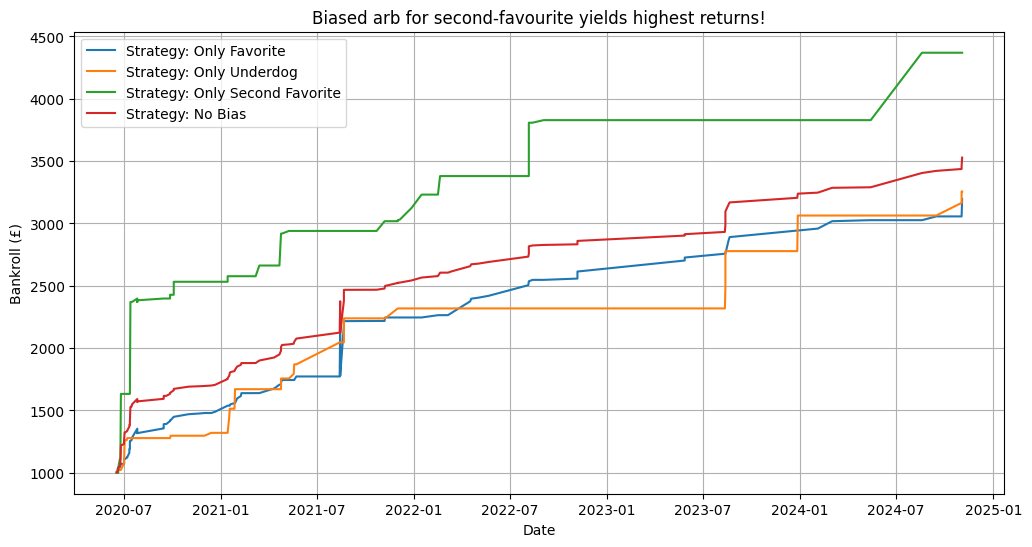

In [53]:
def only_fav_strategy(fav_prob, underdog_prob):
    return "fav"

def only_underdog_strategy(fav_prob, underdog_prob):
    return "underdog"

def only_second_fav_strategy(fav_prob, underdog_prob):
    return "second"

def no_bias_strategy(fav_prob, underdog_prob):
    return "none"

strategies = {
    "Only Favorite": only_fav_strategy,
    "Only Underdog": only_underdog_strategy,
    "Only Second Favorite": only_second_fav_strategy,
        "No Bias": no_bias_strategy,
}

plot_arb_comparison(arb_events_df, 1000, "2020-01-01", "2025-01-01", strategies, "Biased arb for second-favourite yields highest returns!", "arb_strategies_comparison")


### Insight:

Biased arbitrage for second favourite performed the best


This is likely to be due to the consistent and regular nature of profits meaning that is is easier for profits to compound over time, and this effect outweighs the effect of  underdog biased arbitrage offering higher profits less frequently. (as it only pays out if the bias event occurs)

Nonetheless the payouts are still more frequent than underdog biased arbitrage. and although less frequent than favourite bias or comlete unbias. The compensatory increased profit per event leads to quicker compounding of stakes 

Nontheless I still belive I can find an edge over second favourtie bias arbitrage If I create a custom strategy...

---
# 11. Creation of a custom strategies



Now I will be creating a custom strategy based on my prior insights from part 8.) of the notebook.

Note its important to make sure that data leakage isn't occuring but this is hard due to the revealed knowledge I have from my prior EDA

To counterract this I will try to keep my strategy generalised thus still applicable within error, and therefore results and profits wont be too 'cherry picked'

This custom strategy will essentially be deciding to engage in biased vs unbiased behaviour based on the insights from part 8.) 

if there is a strong underdog, biased arb

if there is a weak favourite, then biased arb 

if both exist then unbiased arb

if neither exist, unbiased arb.

it is XOR logic


**Custom strategy from part 8.) insights:**

The custom simple strategy will decide to be bias when betting on weak favourites and strong underdogs, and do so in a static manner. This was informed by part 8.) where we discovered this is when arbitrage tends to outpeform the market.

 I have chosen arbitrary odds values of >0.2 and 0.6< for classifying strong underdogs and wak favourites respectively

 I have calulcted this by looking at the odds where matches with arbitrage opportunites begin to outperform, being 3 and 5 respectively. I then inverted each of these numbers

In [54]:

def custom_strategy_simple(fav_prob, underdog_prob):
    if underdog_prob > 0.2 and fav_prob < 0.6:
        return "none"
    elif underdog_prob > 0.2:
        return "underdog"
    elif fav_prob < 0.6:
        return "fav"
    else:
        return "none"

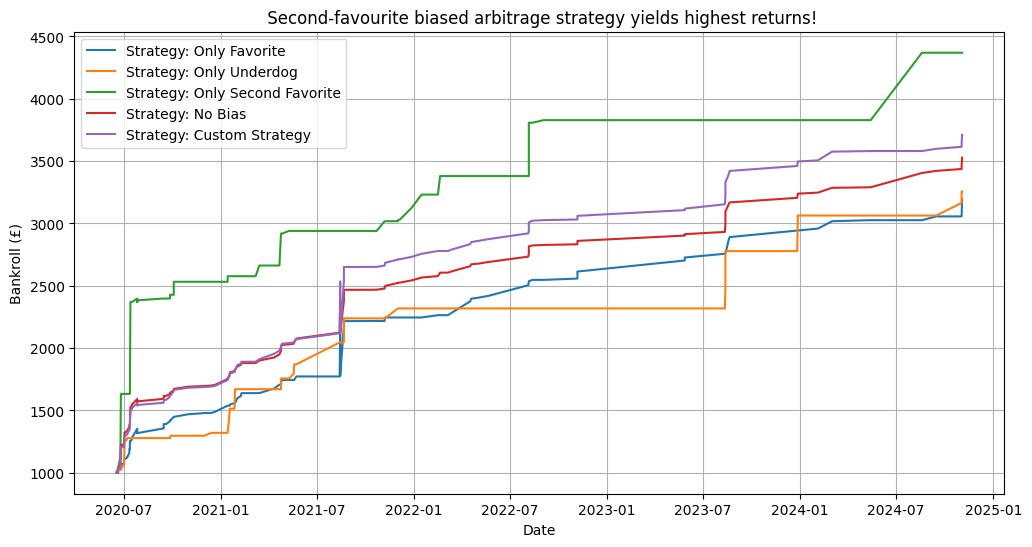

In [55]:
bias_strategies = {
    "Only Favorite": only_fav_strategy,
    "Only Underdog": only_underdog_strategy,
    "Only Second Favorite": only_second_fav_strategy,
    "No Bias": no_bias_strategy,
    "Custom Strategy": custom_strategy_simple,

}


plot_arb_comparison(arb_events_df, 1000, "2020-01-01", "2025-01-01", bias_strategies, " Second-favourite biased arbitrage strategy yields highest returns!", "custom_strategy_comparison")

#### Insight:

Unfortunately the strategy I made didn't beat the second favourite biased arbitrage, thus second favourite bias arbitrage remains the superior strategy

---
# 12. Conclusion

Ultimately I have uncovered more about the nature of arbitrage, especially that it is more prevalent at the start of seasons, and although is declining in prevalence, opportunities still occur.

We also did a basic analysis of how arb events differ from the other events in the sample

We learned that arb events usually tend to have a higher odds difference (thus a clear winner)

We also learned that arb events tend to occur at a greater frequency than implied when i.) there is a weak favourite ii.) there is a strong underdog.

When we simulated strategies we discovered that second favourite biased arbitrage yielded the highest returns



